In [24]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import tqdm
import pickle
warnings.filterwarnings("ignore")

In [25]:
SEED = 1337
np.random.seed(SEED)

In [26]:
SPLIT_DATE_TRAIN = "2020-01-01"
RADIUS = 300
THRESHOLD = 400 
BLOCK_SIZE = 4

In [27]:
df = pd.read_csv("../data/with_features_final.csv")
df.dropna(inplace=True)

In [28]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [29]:
def filter_regions(df: pd.DataFrame, threshold: int, radious: int) -> pd.DataFrame:
    df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
    regions = []
    for pos in tqdm.tqdm(df_f["pos"].unique()):
        lat, lon = pos.split("_")
        lat, lon = float(lat), float(lon)
        diff = int(radious / 111) + 3
        tmp = df_f[(df_f["latitude"] >= lat - diff) & (df_f["latitude"] <= lat + diff) & (df_f["longitude"] >= lon - diff) & (df_f["longitude"] <= lon + diff)]
        tmp["distance"] = haversine_distance(tmp["latitude"], tmp["longitude"], lat + 0.5, lon + 0.5)
        tmp = tmp[tmp["distance"] <= radious]
        if len(tmp) >= threshold:
            regions.append(pos)
    return regions

In [51]:
def make_block(df, pos, radius, block_size):
    lat, lon = pos.split("_")
    lat, lon = float(lat), float(lon)
    tmp1 = df[df["pos"] == pos]
    diff = int(radius / 111) + 3
    tmp2 = df[((df["latitude"] >= lat - diff) & (df["latitude"] <= lat + diff) & (df["longitude"] >= lon - diff) & (df["longitude"] <= lon + diff)) & (df["pos"] != pos)]
    tmp2["label"] = -1
    tmp = pd.concat([tmp1, tmp2], axis=0)
    tmp["distance"] = haversine_distance(tmp["latitude"], tmp["longitude"], lat + 0.5, lon + 0.5)
    tmp = tmp[tmp["distance"] <= radius]
    tmp.sort_values(by=["time"], inplace=True)
    tmp["diff_days"] = (tmp["time"] - tmp["time"].shift(1)).dt.days
    for idx in range(1, block_size):
        tmp["mag_" + str(idx)] = tmp["mag"].shift(idx)
        tmp["depth_" + str(idx)] = tmp["depth"].shift(idx)
        tmp["latitude_" + str(idx)] = tmp["latitude"].shift(idx)
        tmp["longitude_" + str(idx)] = tmp["longitude"].shift(idx)
        tmp["dist_" + str(idx)] = tmp["dist"].shift(idx)
        tmp["distance_" + str(idx)] = tmp["distance"].shift(idx)
        tmp["plate_" + str(idx)] = tmp["plate"].shift(idx)
        tmp["diff_days_" + str(idx)] = tmp["diff_days"].shift(idx)
    # tmp = tmp[tmp["label"] != -1]
    tmp.dropna(inplace=True)
    return tmp

In [52]:
def make_npys(df, radius, th, block_size):
    df["time"] = pd.to_datetime(df["time"], format="mixed")
    df.sort_values(by="time", inplace=True)
    regions = ["72_1"]
    df_final = pd.DataFrame()
    for pos in tqdm.tqdm(regions):
        df_pos = make_block(df, pos, radius, block_size)
        df_final = pd.concat([df_final, df_pos], axis=0)
    return df_final

In [9]:
tmp = make_npys(df, RADIUS, THRESHOLD, BLOCK_SIZE)

100%|██████████| 5955/5955 [1:04:25<00:00,  1.54it/s]


In [10]:
tmp

,time,longitude,latitude,depth,mag,longitude_disc,latitude_disc,pos,lat_cent,lon_cent,...,plate_2,diff_days_2,mag_3,depth_3,latitude_3,longitude_3,dist_3,distance_3,plate_3,diff_days_3
3,1973-01-03,-155.290167,19.399833,7.864,1.76,-156,19,19_-156,19.5,-155.5,...,22.0,0.0,2.21,6.589,19.326000,-155.204333,3521.228924,36.548685,22.0,1.0
6,1973-01-03,-155.277333,19.409500,11.126,1.88,-156,19,19_-156,19.5,-155.5,...,22.0,0.0,3.56,7.752,19.181833,-155.575000,3559.168484,36.243073,22.0,1.0
4,1973-01-03,-155.273667,19.408500,13.166,1.94,-156,19,19_-156,19.5,-155.5,...,22.0,0.0,1.76,7.864,19.399833,-155.290167,3521.146991,24.659571,22.0,0.0
7,1973-01-03,-155.281000,19.430167,15.044,1.99,-156,19,19_-156,19.5,-155.5,...,22.0,0.0,3.05,26.523,19.288833,-156.213000,3595.494765,78.382659,22.0,0.0
8,1973-01-04,-155.393167,19.399167,8.050,2.08,-156,19,19_-156,19.5,-155.5,...,22.0,0.0,1.88,11.126,19.409500,-155.277333,3519.447349,25.422260,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110565,2020-09-27,-68.914900,43.024100,10.000,1.60,-69,43,43_-69,43.5,-68.5,...,12.0,30.0,2.20,5.000,43.993700,-69.801600,2641.594166,118.087991,12.0,5.0
4110566,2022-10-11,-68.006200,43.695300,5.000,1.80,-69,43,43_-69,43.5,-68.5,...,12.0,3.0,1.60,5.074,44.676900,-67.619900,2513.432997,148.545988,18.0,5.0
4110602,2019-12-04,-150.919000,68.022600,11.200,1.10,-151,68,68_-151,68.5,-150.5,...,31.0,0.0,2.30,1.900,67.072800,-154.274200,932.498427,224.334096,31.0,0.0
4110609,2019-12-20,-149.742800,69.741500,34.300,1.90,-150,69,69_-150,69.5,-149.5,...,31.0,0.0,2.80,3.800,69.611300,-145.373800,1026.219184,160.708303,31.0,0.0


In [11]:
# tmp.to_csv("../data/feature_distribution.csv", index=False)

In [5]:
# tmp = pd.read_csv("../data/feature_distribution.csv")

<Axes: >

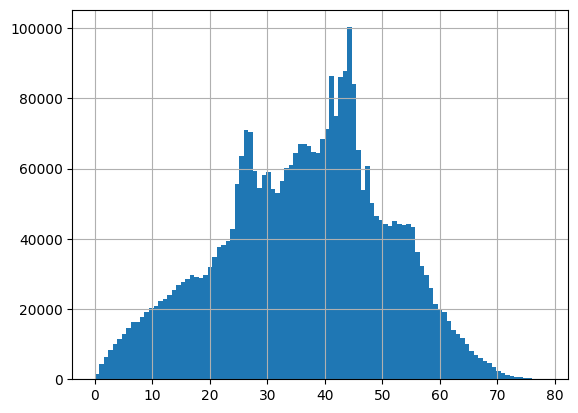

In [14]:
tmp["distance"].hist(bins=100)

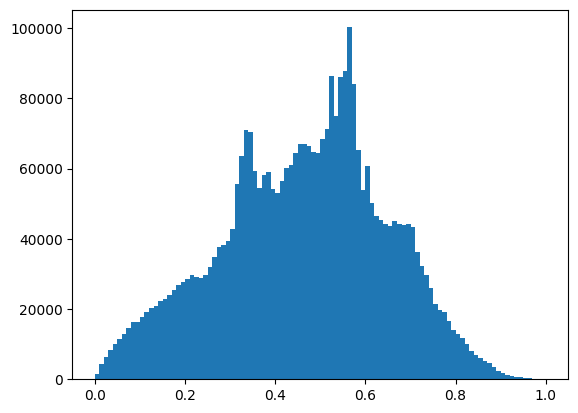

In [15]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["distance"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

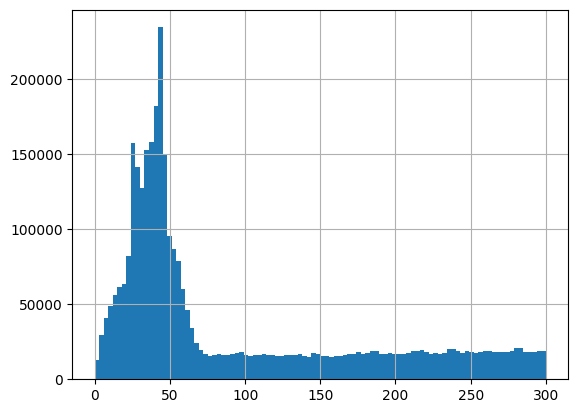

In [16]:
tmp["distance_1"].hist(bins=100)

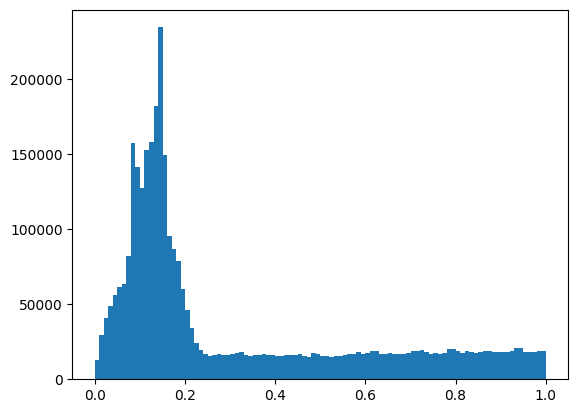

In [17]:
d = scaler.fit_transform(tmp["distance_1"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

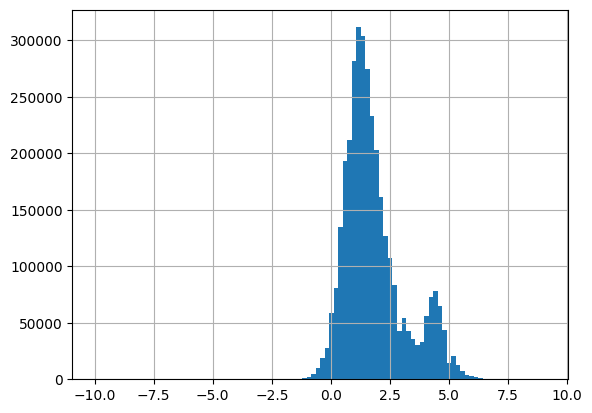

In [18]:
tmp["mag"].hist(bins=100)

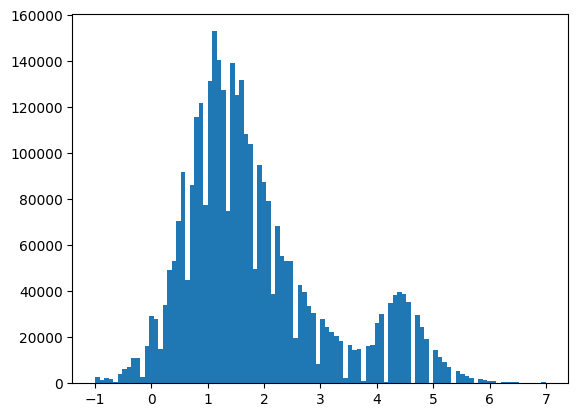

In [19]:
d = np.clip(tmp["mag"].values, -1, 7)
plt.hist(d, bins=100)
plt.show()

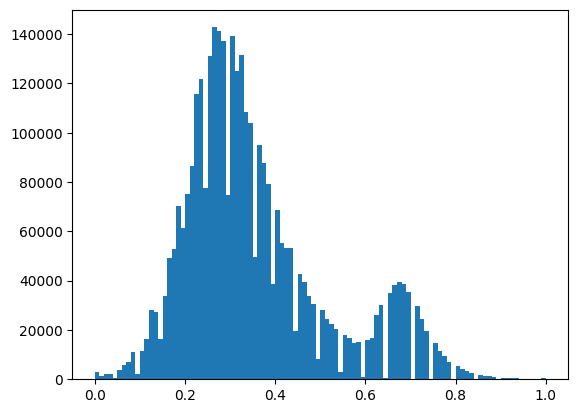

In [20]:
sclaer = MinMaxScaler()
d = sclaer.fit_transform(d.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

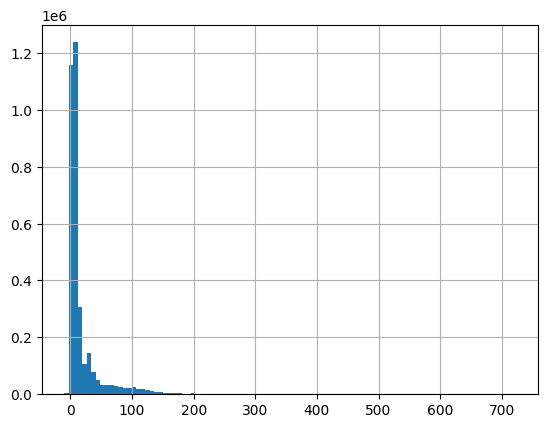

In [21]:
tmp["depth"].hist(bins=100)

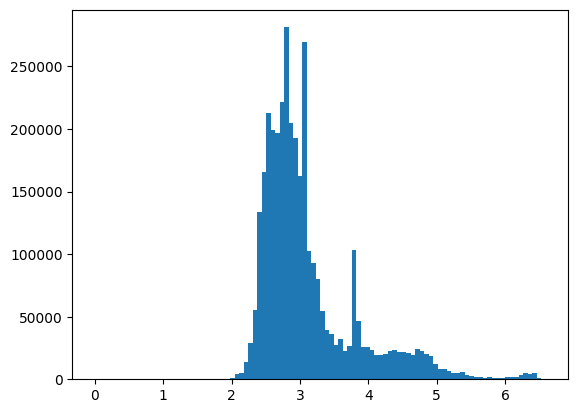

In [22]:
d = np.log(tmp["depth"] + np.abs(tmp["depth"].min()) + 1)
plt.hist(d, bins=100)
plt.show()

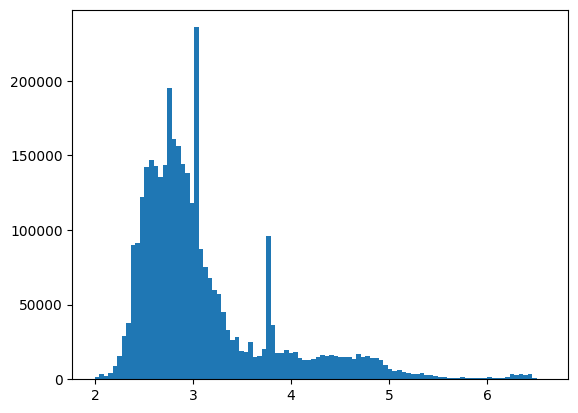

In [23]:
d = np.clip(d, 2, 10)
plt.hist(d, bins=100)
plt.show()

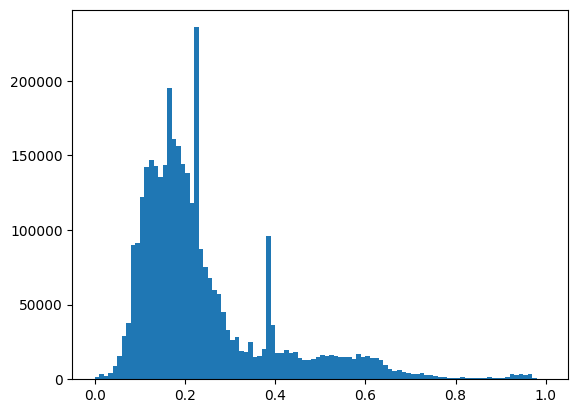

In [24]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

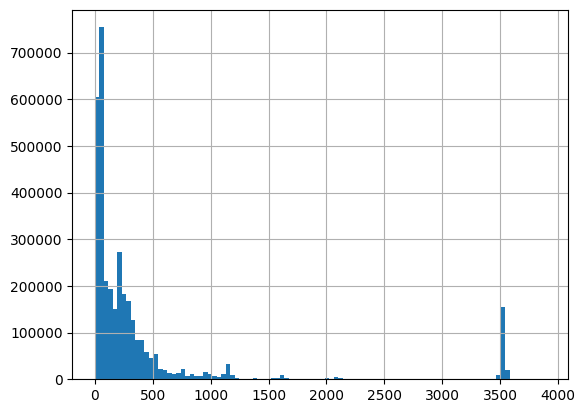

In [25]:
tmp["dist"].hist(bins=100)

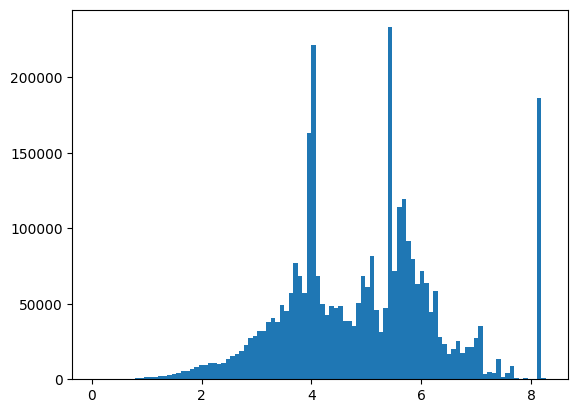

In [26]:
d = np.log(tmp["dist"]+1)
plt.hist(d, bins=100)
plt.show()

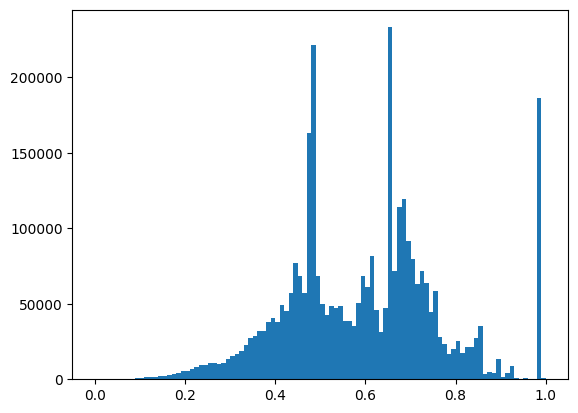

In [27]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

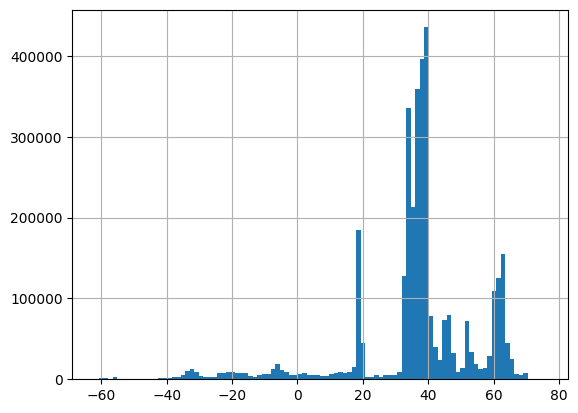

In [29]:
tmp["latitude"].hist(bins=100)

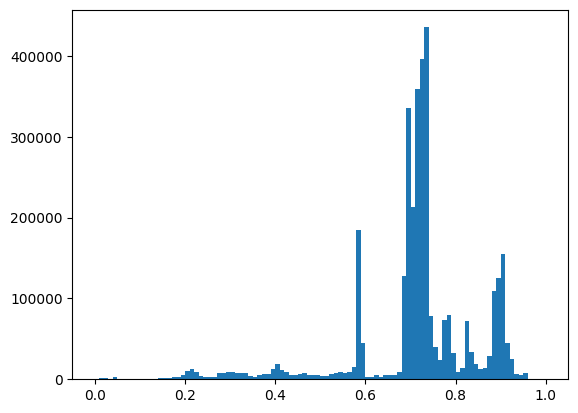

In [30]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["latitude"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()

<Axes: >

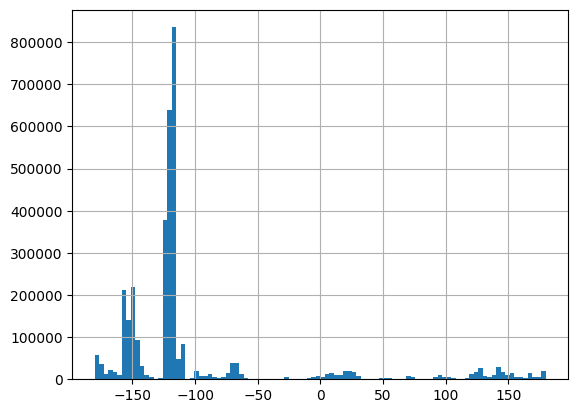

In [31]:
tmp["longitude"].hist(bins=100)

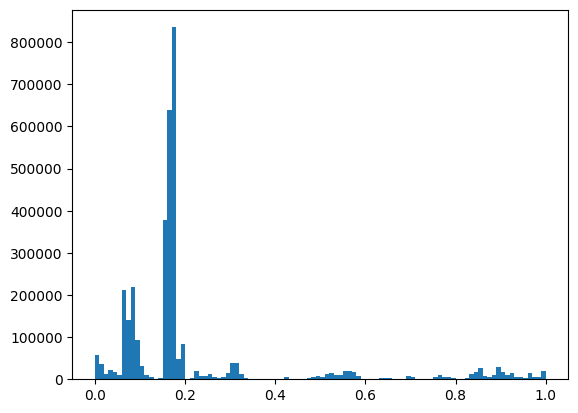

In [32]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["longitude"].values.reshape(-1, 1))
plt.hist(d, bins=100)
plt.show()